In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from sklearn import svm
from sklearn import mixture
from sklearn.metrics import confusion_matrix
import glob
from helpers import ImageManager

In [2]:
# Get Data using the Helper Class
mng = ImageManager()
training = dict()
testing = dict()
testing["images"] = mng.get_testing_images()
training["images"] = mng.get_training_images()
_, testing["bounds"] = mng.update_testing_bounds()
_, training["bounds"] = mng.update_training_bounds()

# 4.1) Training: Building Vocabulary

In [3]:
K = 15

In [4]:
def sift_feats(imgs_dict, K, draw = False, clf=None):
  
    images = imgs_dict["images"]
    bounds = imgs_dict["bounds"]
    
    num_imgs_per_person = int(len(images)/5)

    sift_feats = []

    if(draw):
        plt.figure(figsize=(20, 70))
    
    for i, img in enumerate(images):

        img_disp = img.copy()

        # create a SIFT object
        sift = cv2.xfeatures2d.SIFT_create()

        # detect SIFT features, with no masks
        keypoints = sift.detect(img, None)

        keypoints_filtered = []
        for kp in keypoints:
            point = kp.pt;
            if(point[0] > bounds[i]["min_x"] and 
               point[0] < bounds[i]["max_x"] and 
               point[1] > bounds[i]["min_y"] and 
               point[1] < bounds[i]["max_y"]):
                keypoints_filtered.append(kp)

        keypoints = keypoints_filtered

        # compute SIFT descriptors
        keypoints, descriptors = sift.compute(img, keypoints)
        
        if clf is None:
            clf = mixture.GaussianMixture(n_components = K, covariance_type='full', init_params = 'kmeans')

            # fit GMM on train data
            clf.fit(descriptors)

            # reference: https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column
            # sorting in ascending order
            clf.means_ = clf.means_[np.lexsort(np.fliplr(clf.means_).T)]
        
        # predict cluster membership from the fitted GMM 
        labels = clf.predict(descriptors)

        feats_dict = {"descriptors" : descriptors, "labels" : labels}

        sift_feats.append(feats_dict)

        # draw the keypoints
        cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        if(draw):
            # display images
            plt.subplot(num_imgs_per_person, 5, (math.floor(i/num_imgs_per_person) + 1 + 5 * (i % num_imgs_per_person)))
            plt.imshow(img_disp)

    
    plt.show()
    
    return sift_feats, clf

In [5]:
def BoW(imgs_dict, K):
    
    sift_feats = imgs_dict["sift"]
    
    for sift in sift_feats:
        freq = []
        for k in range(K):
            freq.append(np.count_nonzero(sift["labels"] == k))

        sift["histogram"] = freq/np.linalg.norm(freq)
    
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.bar(range(K), sift_feats[i]["histogram"], edgecolor='k' )
        plt.xlim([-1, K]) # set x-axis limit
    plt.show()
    
    return sift_feats

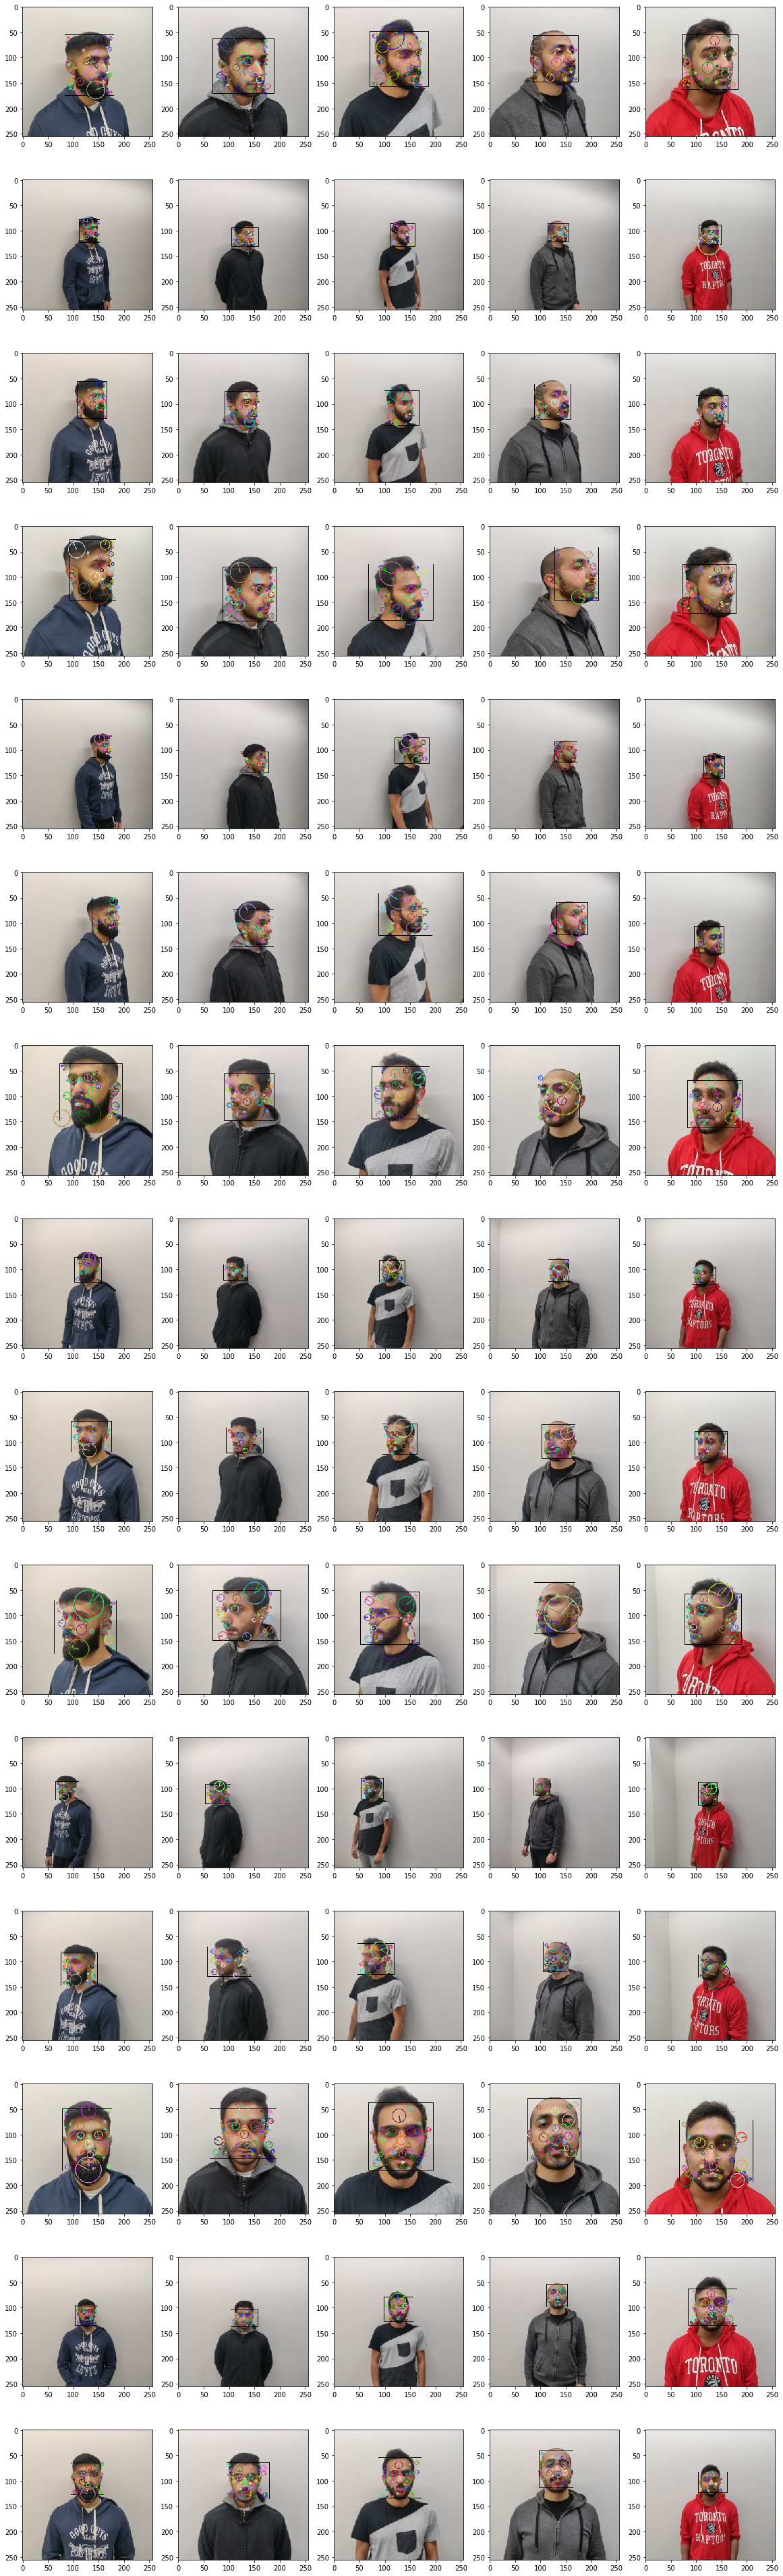

In [6]:
training["sift"], gmm_clf = sift_feats(training, K, draw = True)

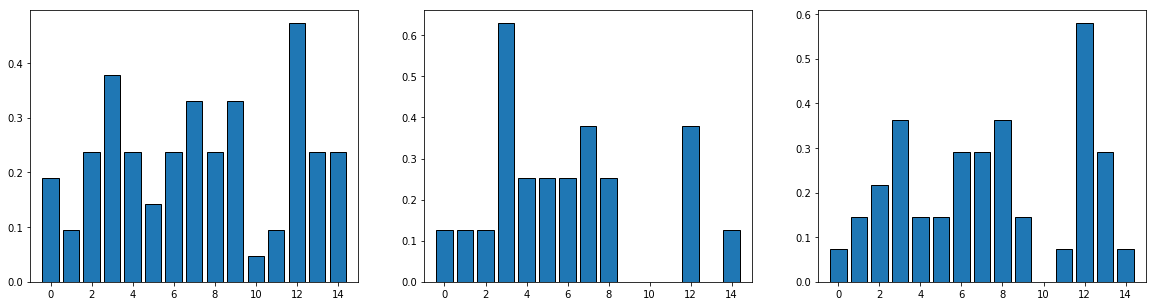

In [7]:
training["sift"] = BoW(training, K)

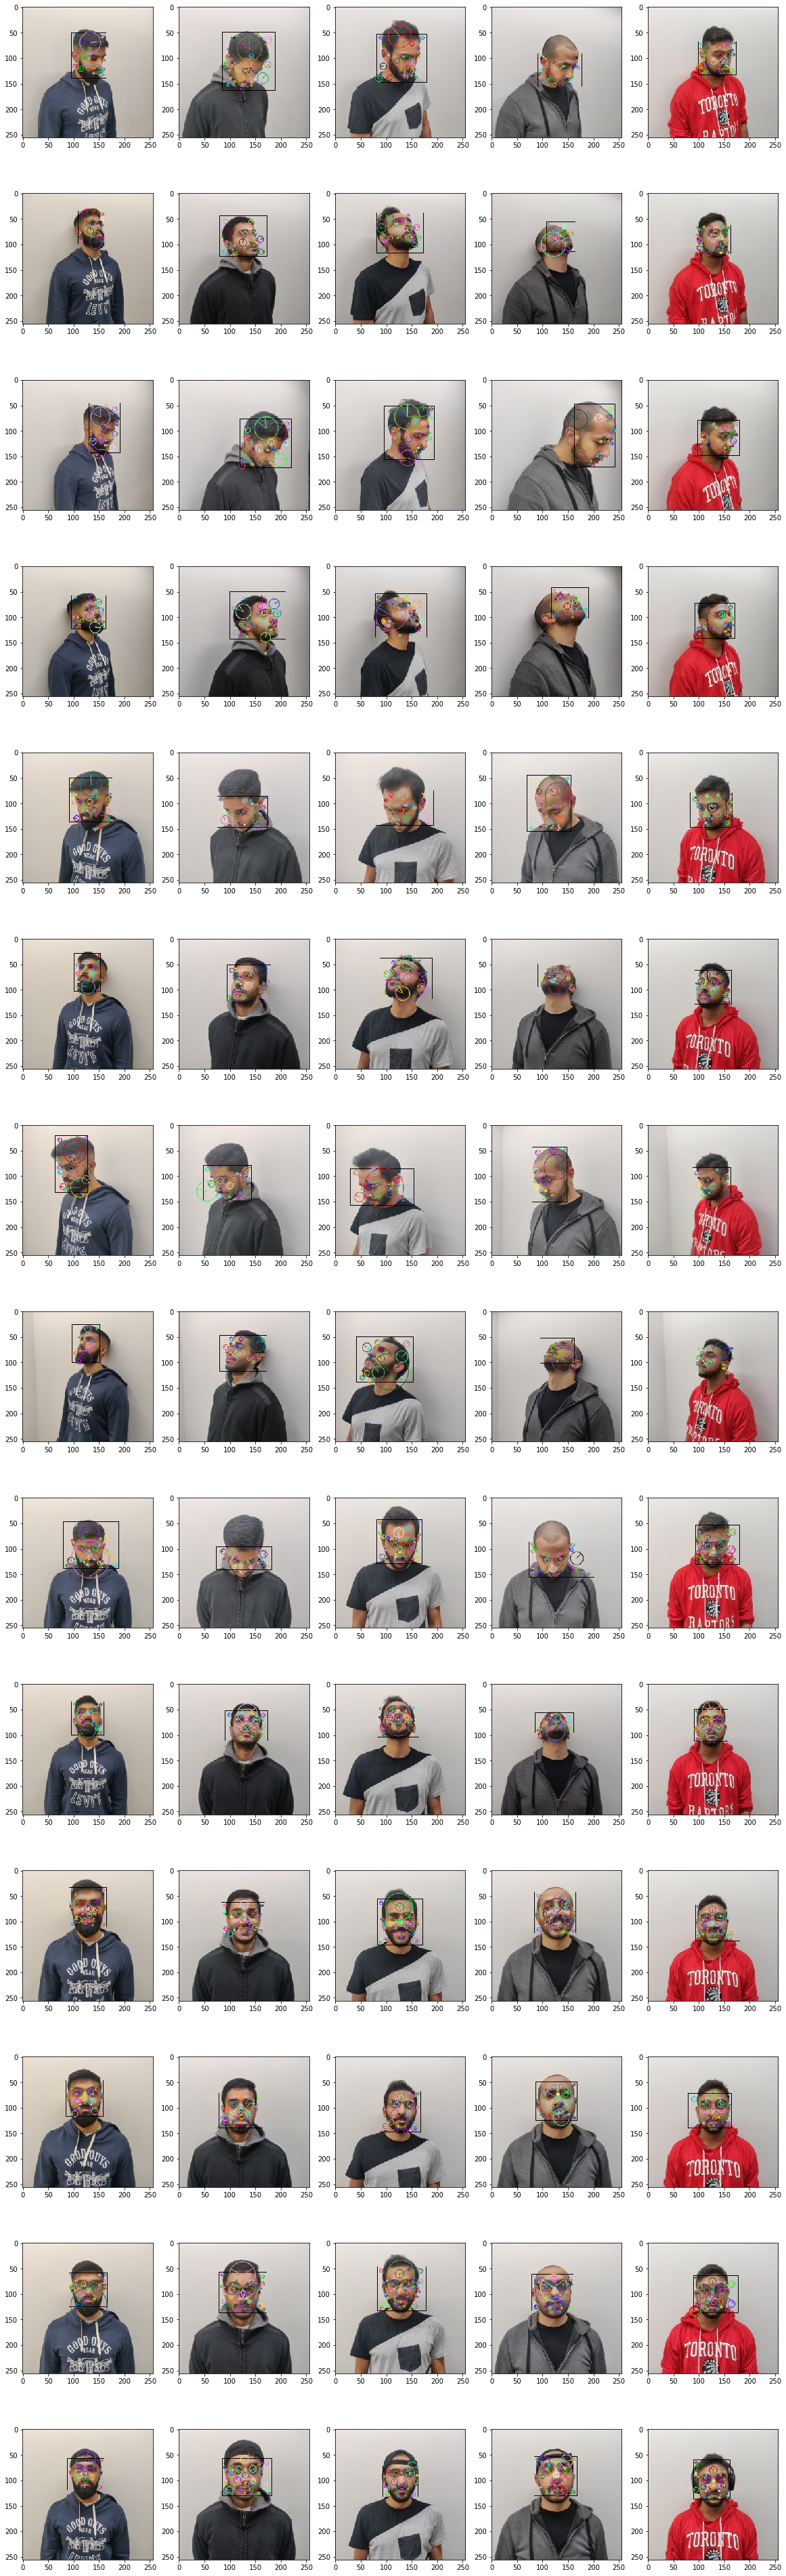

In [8]:
testing["sift"], _ = sift_feats(testing, K, draw = True, clf=gmm_clf)

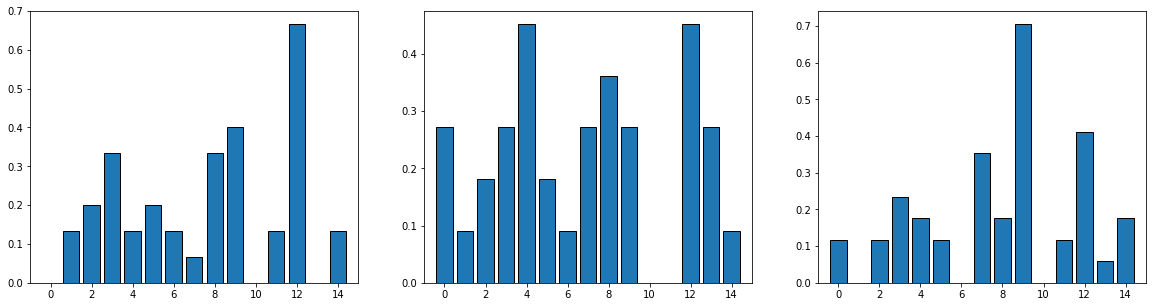

In [9]:
testing["sift"] = BoW(testing, K)

In [10]:
def difference(hist_1, hist_2):
    hist_1 = np.array(hist_1)
    hist_2= np.array(hist_2)
    diff = np.linalg.norm(hist_1 - hist_2)
    return diff

In [11]:
identities = []
for j, testing_sift in enumerate(testing["sift"]):
    closest_idx = 0
    min_diff = 1000
    diff = 0
    for i, training_sift in enumerate(training["sift"]):
        diff = difference(testing_sift["histogram"], training_sift["histogram"])
        if(diff < min_diff):
            min_diff = diff
            closest_idx = i
    
    if(closest_idx >= 0 and closest_idx < 15):
        identities.append("Abdullah")
    elif(closest_idx >= 15 and closest_idx < 30):
        identities.append("Mustafa")
    elif(closest_idx >= 30 and closest_idx < 45):
        identities.append("Saleh")
    elif(closest_idx >= 45 and closest_idx < 60):
        identities.append("Adham")
    else:
        identities.append("Anees")


In [12]:
ids = ["Abdullah", "Mustafa", "Saleh", "Adham", "Anees"]

true_ids = []
for ID in ids:
    for i in range(14):
        true_ids.append(ID)
    
correct = 0
for i in range(70):
    correct += identities[i] == true_ids[i]

correct/70

0.3142857142857143